All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 171:
> This question should be answered using the `Weekly` data set, which is part of the `ISLR` package. This data is similar in nature to the `Smarket` data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis \
                                          , QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm


%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
weekly = pd.read_csv('https://raw.githubusercontent.com/dsnair/ISLR/master/data/csv/Weekly.csv')
weekly.head(3)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up


Columns (information taken from [here](https://rdrr.io/cran/ISLR/man/Weekly.html)):
* `Year` &mdash; the year that the observation was recorded;
* `Lag1` &mdash; percentage return for previous week;
* `Lag2` &mdash; percentage return for 2 weeks previous;
* `Lag3` &mdash; percentage return for 3 weeks previous;
* `Lag4` &mdash; percentage return for 4 weeks previous;
* `Lag5` &mdash; percentage return for 5 weeks previous;
* `Volume` &mdash; volume of shares traded (average number of daily shares traded in billions);
* `Today` &mdash; percentage return for this week;
* `Direction` &mdash; a factor with levels Down and Up indicating whether the market had a positive or negative return on a given week.

In [3]:
weekly_dummy = pd.get_dummies(weekly, drop_first=True)
weekly_dummy['week'] = np.arange(1, len(weekly)+1)

# (a)

From the textbook, p.171:
> Produce some numerical and graphical summaries of the `Weekly` data. Do there appear to be any patterns?

In [4]:
weekly_dummy.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up,week
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556,545.000000
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132,314.511526
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000,1.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000,273.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000,545.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000,817.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000,1089.000000


In [5]:
weekly_dummy.isna().any().any()

False

There are no empty values.

Notes:
* There are no empty values.
* The distributions of lags seem to be roughly the same. This is expected, because lags are running variables &mdash; each of them is going through the same values.

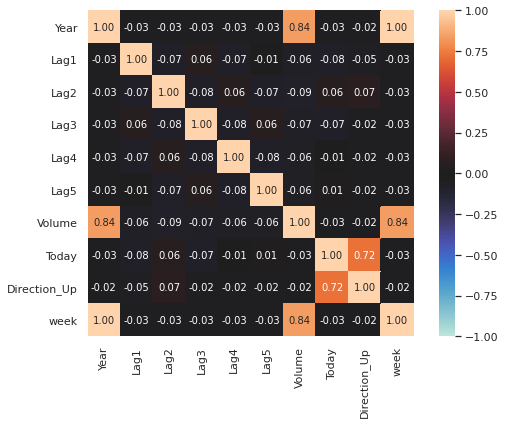

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(weekly_dummy.corr()
            , vmin=-1
            , vmax=1
            , annot=True
            , fmt='.2f'
            , square=True
            , cmap='icefire'
)
plt.tight_layout()

`Year` and `week` have, expectedly, a perfect positive correlation. `Volume` seem to grow together with both of them. The rest of the predictors are not correlated at all.

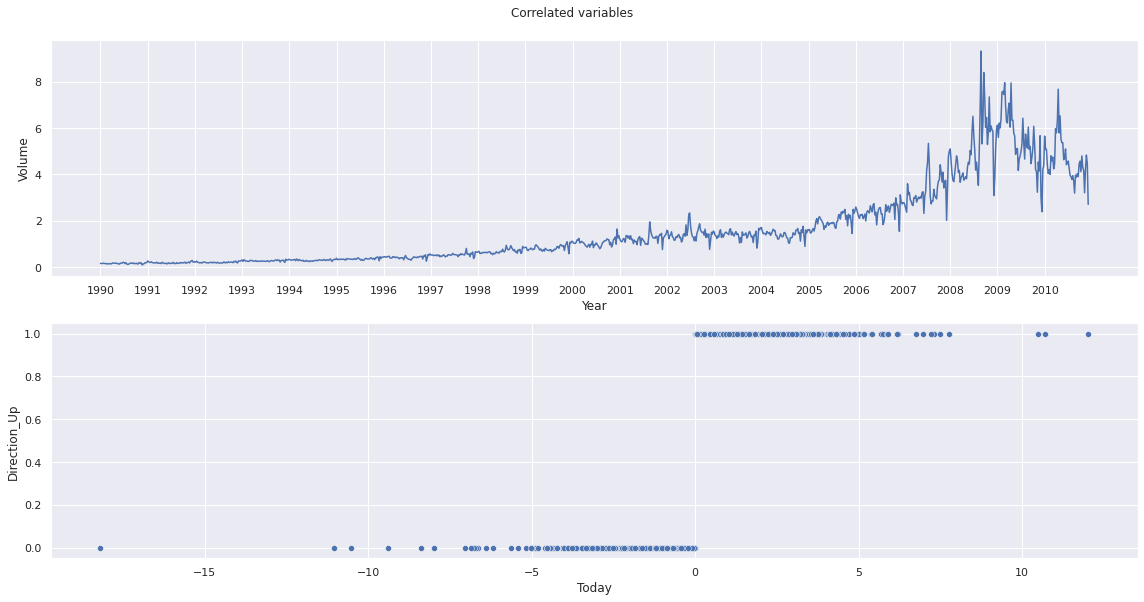

In [7]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(16, 8))
axs = axs.flatten()
sns.lineplot(x='week', y='Volume', data=weekly_dummy, ax=axs[0])
axs[0].set_xticks(np.arange(1, len(weekly)+1, 52))
axs[0].set_xticklabels(weekly_dummy.Year.unique())
axs[0].set_xlabel('Year')
sns.scatterplot(x='Today', y='Direction_Up', data=weekly_dummy, ax=axs[1])
plt.suptitle('Correlated variables', y=1.04)
plt.tight_layout()

# (b)

From the textbook, p.171:
> Use the full data set to perform a logistic regression with `Direction` as the response and the five lag variables plus `Volume` as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [8]:
y = pd.get_dummies(weekly.Direction, drop_first=True)
x = weekly.drop('Direction', axis='columns').assign(Intercept=1)

In [9]:
model_b = sm.Logit(y, x.drop(['Year', 'Today'], axis='columns')).fit()
print(model_b.summary())

Optimization terminated successfully.
         Current function value: 1.925080
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                     inf
Time:                        20:02:32   Log-Likelihood:                -2096.4
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:3390: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


`Lag2` appears to be statistically significant.

# (c)

From the textbook, p.171:
> Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [10]:
cm = model_b.pred_table()
print(f'Confusion matrix:\n{cm}\n')
print('Model accuracy:', np.diag(cm).sum() / cm.sum())

Confusion matrix:
[[ 54. 430.]
 [ 48. 557.]]

Model accuracy: 0.5610651974288338


# (d)

From the textbook, p.171:
> Now fit the logistic regression model using a training data period from 1990 to 2008, with `Lag2` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [11]:
model_d = sm.Logit(y, x[['Intercept', 'Lag2']]).fit()
cm = model_d.pred_table()
print(f'\nConfusion matrix:\n{cm}\n')
print('Model accuracy:', np.diag(cm).sum() / cm.sum())

Optimization terminated successfully.
         Current function value: 1.095346
         Iterations 4

Confusion matrix:
[[ 33. 451.]
 [ 26. 579.]]

Model accuracy: 0.5619834710743802


# (e)

From the textbook, p.171:
> Repeat (d) using LDA.

In [17]:
model_e = LinearDiscriminantAnalysis()
model_e.fit(x[['Lag2']], y.to_numpy().ravel())
cm_e = confusion_matrix(y.to_numpy().ravel(), model_e.predict(x[['Lag2']]))
print(f'Confusion matrix:\n{cm_e}\n')
print('Model accuracy:', np.diag(cm_e).sum() / cm_e.sum())

Confusion matrix:
[[ 33 451]
 [ 25 580]]

Model accuracy: 0.5629017447199265


# (f)

From the textbook, p.171:
> Repeat (d) using QDA.

In [20]:
model_f = QuadraticDiscriminantAnalysis()
model_f.fit(x[['Lag2']], y.to_numpy().ravel())
cm_f = confusion_matrix(y.to_numpy().ravel(), model_f.predict(x[['Lag2']]))
print(f'Confusion matrix:\n{cm_f}\n')
print('Model accuracy:', np.diag(cm_f).sum() / cm_f.sum())

Confusion matrix:
[[  0 484]
 [  0 605]]

Model accuracy: 0.5555555555555556


# (g)

From the textbook, p.171:
> Repeat (d) using KNN with K = 1.

In [19]:
model_g = KNeighborsClassifier(n_neighbors=1)
model_g.fit(x[['Lag2']], y.to_numpy().ravel())
cm_g = confusion_matrix(y.to_numpy().ravel(), model_g.predict(x[['Lag2']]))
print(f'Confusion matrix:\n{cm_g}\n')
print('Model accuracy:', np.diag(cm_g).sum() / cm_g.sum())

Confusion matrix:
[[459  25]
 [ 20 585]]

Model accuracy: 0.9586776859504132


# (h)

From the textbook, p.171:
> Which of these methods appear to provide the best results on this data?

KNN, by far.

# (i)

From the textbook, p.171:
> Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

I have procrastinated on this nebulous task for a day. I'm leaving it for now; will return later (maybe).